# Financial Exploratory Analysis

This exploratory analysis seeks to better understand issues and relationships surrounding financial data. The data sources are from two categories: public domain financial data and textual data. 

## Get S&P500 stocker tickers and related data

In [18]:
import bs4 as bs
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pickle
import requests
from collections import Counter
from sklearn import svm, model_selection as cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from urllib.request import urlretrieve

style.use('ggplot')

In [21]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        mapping = str.maketrans(".","-")
        ticker = ticker.translate(mapping)
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

In [25]:
#save_sp500_tickers()

In [27]:
# save_sp500_tickers()
def get_data_from_yahoo(reload_sp500=False):  # (reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            #df = df.drop("Symbol", axis=1)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

In [28]:
get_data_from_yahoo(reload_sp500=True)

In [29]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [49]:
#compile_data()

## Exploratory analysis for relationships in the data

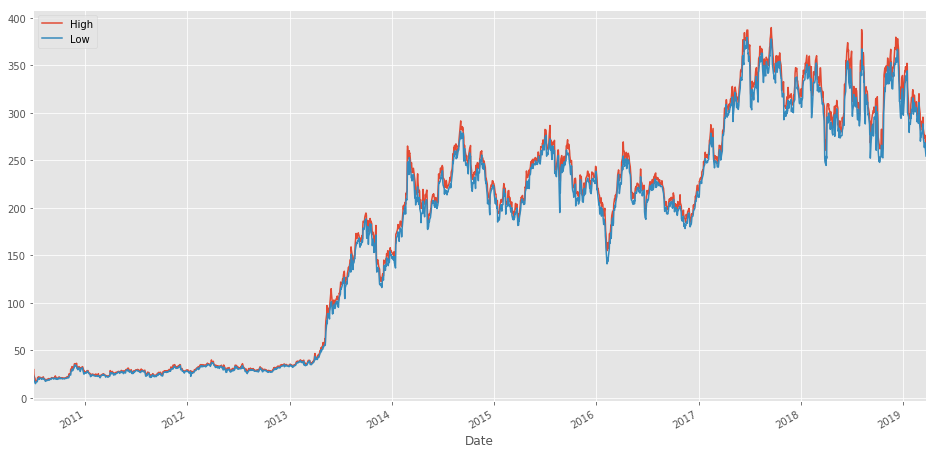

In [31]:
# Plot various stats from selected ticker data
#
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
df = web.DataReader('TSLA', 'yahoo', start, end)

#df.head()
df.to_csv('tsla.csv')
df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)

plt.rcParams['figure.figsize'] = [16, 8]

#df['Adj Close'].plot()
df[['High','Low']].plot()

In [32]:
# Create 100 day rolling average data as a column in dataset
#
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()
df.tail()  # examine the new '100ma' column data

,High,Low,Open,Close,Volume,Adj Close,100ma
Date,,,,,,,
2019-03-19,273.299988,263.459991,267.500000,267.470001,11800600,267.470001,321.974200
2019-03-20,274.970001,266.299988,269.690002,273.600006,6908200,273.600006,321.768800
2019-03-21,276.450012,268.450012,272.600006,274.019989,5947100,274.019989,321.624000
2019-03-22,272.799988,264.000000,272.579987,264.529999,8732600,264.529999,321.120700
2019-03-25,262.000000,254.460007,259.709991,261.319397,4757820,261.319397,320.424894


<BarContainer object of 2199 artists>

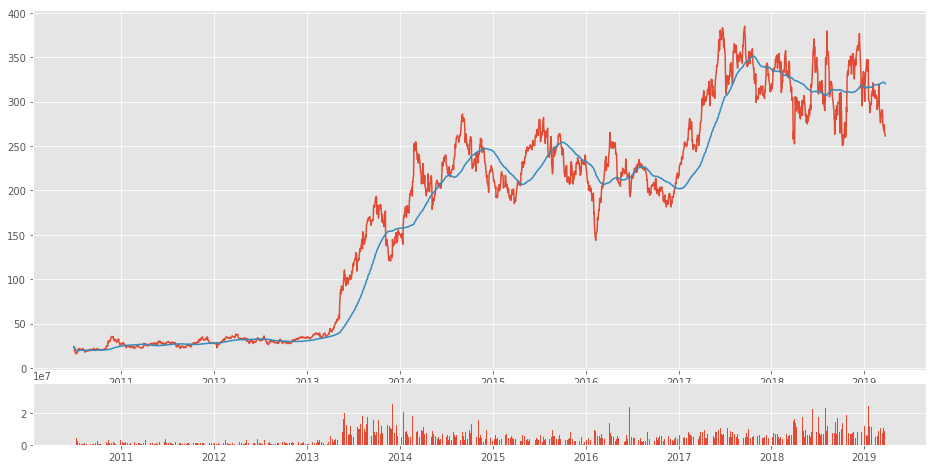

In [33]:
# Configure plot
plt.rcParams['figure.figsize'] = [16, 8]

ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)  # share the X axis for zooming :)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])

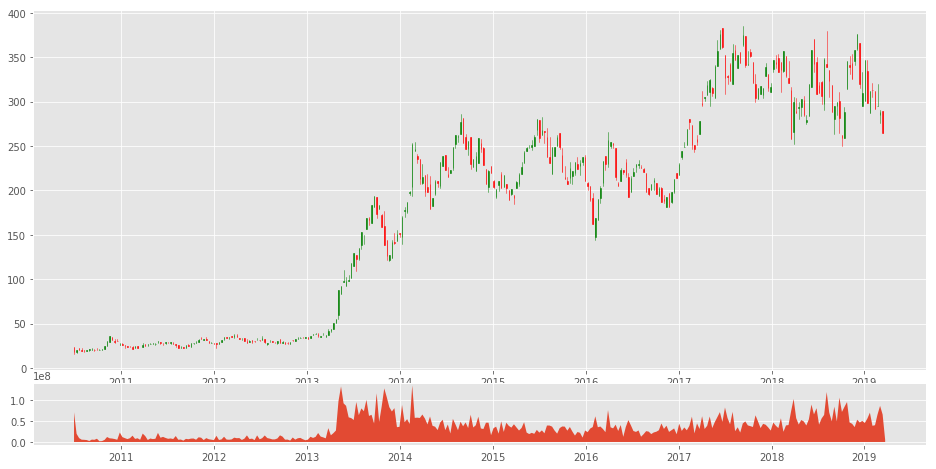

In [34]:
# Candlestick plot vs Volume

df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc = df_ohlc.reset_index()
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

plt.rcParams['figure.figsize'] = [16, 8]
fig = plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)  # share the X axis for zooming :)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
plt.show()

In [35]:
# Visualize the correlation of ticker 'Adj Close' data - the plot is massive
def visualize_data_correlation():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
    #print(df_corr.head())
    df_corr.to_csv('sp500corr.csv')
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()


           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.916015  0.929138  0.815972  0.963352  0.931925  0.896195   
ABT   0.916015  1.000000  0.892186  0.892356  0.951624  0.858083  0.941822   
ABBV  0.929138  0.892186  1.000000  0.887613  0.934059  0.908800  0.920436   
ABMD  0.815972  0.892356  0.887613  1.000000  0.912158  0.898558  0.978549   
ACN   0.963352  0.951624  0.934059  0.912158  1.000000  0.948435  0.954831   

           AMD       AAP       AES  ...      WLTW      WYNN       XEL  \
MMM   0.537422  0.716052  0.504191  ...  0.952188  0.427697  0.962769   
ABT   0.602026  0.717644  0.691791  ...  0.934071  0.432056  0.927662   
ABBV  0.749146  0.218935  0.373623  ...  0.916856  0.210127  0.851197   
ABMD  0.791949  0.520892  0.612458  ...  0.856408  0.295649  0.854095   
ACN   0.624353  0.703296  0.556321  ...  0.956413  0.372519  0.972030   

           XRX      XLNX       XYL       YUM       ZBH      ZION       ZTS  
MMM   0.605837 

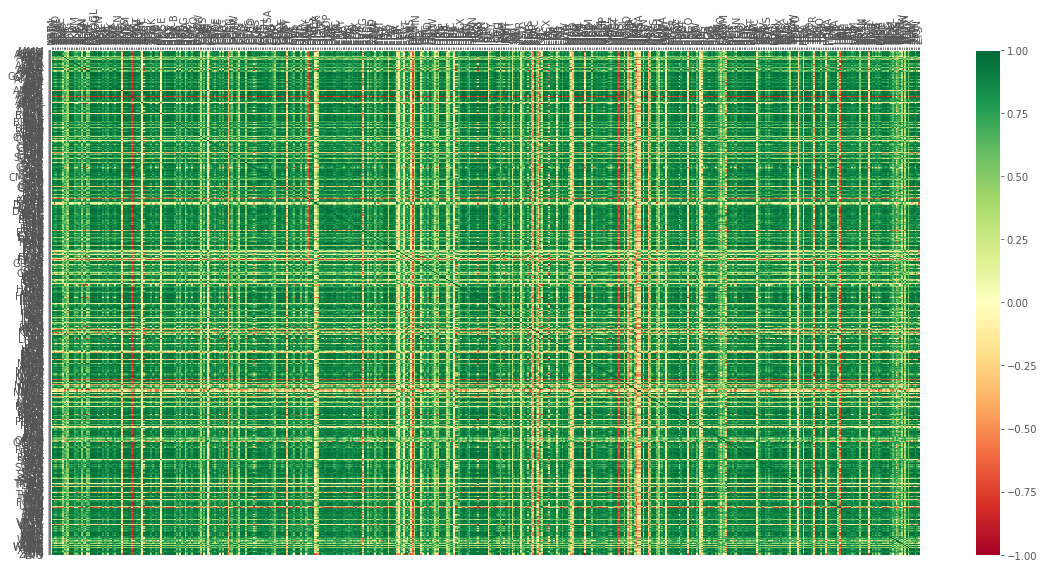

In [36]:
visualize_data_correlation()

## Begin ML

Convert data to featuresets, map them to defined labels.

This exploration analyses ticker price changes for all companies and map the results to buy, sell or hold labels. The trigger for each label will be a declared percentage of price change. Results are analyzed to determine actual spread, predicted spread and accuracy of the prediction.

In [68]:
# Preprocessing for ML modeling

def process_data_for_labels(ticker):
    """blah"""
    predict_days = 7  # predict future price in days
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, predict_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    
    df.fillna(0, inplace=True)
    return tickers, df

In [69]:
#process_data_for_labels('BAC')

In [70]:
# Function that creates our 'buy-sell-hold' labels
def buy_sell_hold(*args):
    """blah"""
    cols = [c for c in args]
    requirement = 0.02  # 2% change fires buy or sell trigger
    for col in cols:
        if col > requirement:
            return 1  # buy
        if col < -requirement:
            return -1  # sell
    return 0

In [74]:
# Create dataset and 'target' column (label) from any ticker
def extract_bsh_featuresets(ticker):
    """blah"""
    predict_days = 7
    tickers, df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]
                                               ))

    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    
    print(ticker)
    print('Data spread: ', Counter(str_vals))
    
    # Clean up missing data replacing gaps with 0, replace infinte values to NaNs, then drop the NaNs 
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()  # normalize the values
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    # X are featuresets, y are labels
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [75]:
extract_bsh_featuresets('AAPL')

AAPL
Data spread:  Counter({'1': 1075, '-1': 860, '0': 386})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.00626362, -0.00807892,  0.        , ...,  0.03165583,
          0.03525875,  0.        ],
        [ 0.01418175,  0.00555341,  0.        , ..., -0.00032285,
          0.08695665,  0.        ],
        ...,
        [ 0.00628899,  0.00150106,  0.01007084, ...,  0.01671504,
         -0.02250056,  0.0115736 ],
        [-0.02361527, -0.02610538, -0.01821757, ..., -0.02222906,
         -0.05233442, -0.01716177],
        [-0.00224766, -0.00192384, -0.01416756, ..., -0.00600571,
          0.00486942, -0.00153172]]),
 array([-1, -1, -1, ..., -1,  0,  0]),
                    MMM        ABT       ABBV        ABMD         ACN  \
 Date                                                                   
 2010-01-04   65.798973  18.524536   0.000000    8.740000   34.431107   
 2010-01-05   65.386833  18.374878   0.000000    8.530000   34.643883   
 2010-01-06   66.314133  18.476921   0.000

In [58]:
# ML Classifier
def do_ml(ticker):
    """blah"""
    X, y, df = extract_bsh_featuresets(ticker)
    
    # Shuffle the data and create training and testing samples ensuring we do not test the algorithm on same data
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    #clf = neighbors.KNeighborsClassifier()  # select KNearestNeighbor
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                             ('knn', neighbors.KNeighborsClassifier()),
                             ('rfor', RandomForestClassifier(n_estimators=100))])
    
    clf.fit(X_train, y_train)  # X_train is the % change for all the tickers, y is the target: 0, 1 or -1
    confidence = clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    
    print('Predicted spread: ', Counter(predictions))
    print('Accuracy: ', confidence)
    print()
    
    return confidence
    

In [64]:
do_ml('XOM')
#do_ml('BAC')

XOM
Data spread:  Counter({'0': 894, '1': 767, '-1': 660})
Predicted spread:  Counter({0: 308, -1: 171, 1: 102})
Accuracy:  0.4113597246127367



0.4113597246127367

In [ ]:
#
#from statistics import mean

#with open("sp500tickers.pickle", "rb") as f:
#    tickers = pickle.load(f)
#    
#accuracies = []
#for count, ticker in enumerate(tickers):
#    if count % 10 == 0:
#        print(count)
#    
#    accuracy = do_ml(ticker)
#    accuracies.append(accuracy)
#    print("{} accuracy: {}. Average accuracy: {}".format(ticker,accuracy,mean(accuracies)))
#    print()
    